Bibliotecas

In [ ]:
# Instalar bibliotecas (caso necessário)
!pip install datasets transformers nltk
!pip install -U datasets huggingface_hub


# Imports principais
import numpy as np
import pandas as pd
import torch
import nltk
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.3/489.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.31.2
    Uninstalling huggingface-hub-0.31.2:
      Successfully uninstalled huggingface-hub-0.31.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_sy

carregamento do dataset

In [ ]:
dataset = load_dataset("dair-ai/emotion", cache_dir="./hf_cache")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

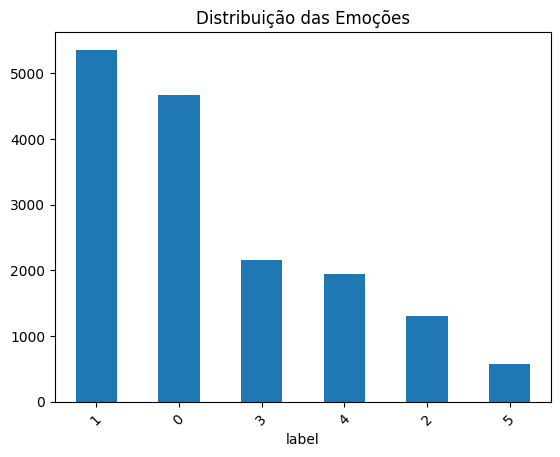

In [ ]:
# Convertendo para pandas para facilitar a visualização
df_train = pd.DataFrame(dataset["train"])
df_test = pd.DataFrame(dataset["test"])
df_val = pd.DataFrame(dataset["validation"])

# Visualizando o balanceamento de classes
df_train["label"].value_counts().plot(kind="bar", title="Distribuição das Emoções")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Baixar e carregar GloVe embeddings (versão para Twitter 100d)
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip -q glove.twitter.27B.zip

# Carregando os vetores
import numpy as np

embedding_dim = 100
glove_path = "glove.twitter.27B.100d.txt"
embeddings_index = {}

with open(glove_path, 'r', encoding="utf-8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Total palavras nos embeddings: {len(embeddings_index)}")


--2025-05-20 19:58:58--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2025-05-20 19:58:59--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2025-05-20 19:58:59--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [ap

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Juntando todos os textos para treinar o tokenizer
texts = dataset["train"]["text"] + dataset["validation"]["text"] + dataset["test"]["text"]

# Configurando o tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

vocab_size = len(tokenizer.word_index) + 1
print(f"Tamanho do vocabulário: {vocab_size}")


Tamanho do vocabulário: 17098


In [ ]:
# Função utilitária
def encode_data(texts, labels, max_len=50):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post')
    return torch.tensor(padded), torch.tensor(labels)

# Conjuntos
X_train, y_train = encode_data(dataset["train"]["text"], dataset["train"]["label"])
X_val, y_val = encode_data(dataset["validation"]["text"], dataset["validation"]["label"])
X_test, y_test = encode_data(dataset["test"]["text"], dataset["test"]["label"])


In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


modelo LSTM

In [ ]:
import torch.nn as nn

class EmotionLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(EmotionLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.5)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        last_hidden = lstm_out[:, -1, :]
        out = self.dropout(last_hidden)
        out = self.fc(out)
        return out

# Hiperparâmetros
hidden_dim = 256
output_dim = len(set(dataset["train"]["label"]))

model = EmotionLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)


data loaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch_x, batch_y in loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            total_loss += loss.item()
            preds = torch.argmax(output, dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)

    acc = correct / total
    return total_loss / len(loader), acc


In [ ]:
# Loop de treinamento com salvamento do melhor modelo
epochs = 20
best_val_loss = float('inf')
patience = 3
trigger_times = 0

for epoch in range(epochs):
    start = time.time()
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    end = time.time()

    print(f"Época {epoch+1}/{epochs}")
    print(f"→ Tempo: {end-start:.2f}s")
    print(f"→ Loss treino: {train_loss:.4f}")
    print(f"→ Loss validação: {val_loss:.4f} | Acurácia: {val_acc:.4f}")
    print("-" * 40)

    # Early stopping simples
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")

Época 1/20
→ Tempo: 150.32s
→ Loss treino: 1.7930
→ Loss validação: 1.7919 | Acurácia: 0.3320
----------------------------------------
Época 2/20
→ Tempo: 156.22s
→ Loss treino: 1.7927
→ Loss validação: 1.7933 | Acurácia: 0.1380
----------------------------------------
Época 3/20
→ Tempo: 151.03s
→ Loss treino: 1.7912
→ Loss validação: 1.7936 | Acurácia: 0.3450
----------------------------------------
Época 4/20
→ Tempo: 155.71s
→ Loss treino: 1.7883
→ Loss validação: 1.7923 | Acurácia: 0.0955
----------------------------------------
Época 5/20
→ Tempo: 149.72s
→ Loss treino: 1.7829
→ Loss validação: 1.7988 | Acurácia: 0.0930
----------------------------------------
Época 6/20
→ Tempo: 150.39s
→ Loss treino: 1.7768
→ Loss validação: 1.7962 | Acurácia: 0.3330
----------------------------------------
Época 7/20
→ Tempo: 149.59s
→ Loss treino: 1.7721
→ Loss validação: 1.8094 | Acurácia: 0.2920
----------------------------------------
Época 8/20
→ Tempo: 155.62s
→ Loss treino: 1.7563
→ Los

In [ ]:
def test_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device)
            output = model(batch_x)
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.numpy())

    return all_preds, all_labels

# Carregar melhor modelo
model.load_state_dict(torch.load("best_model.pt"))

# Predição e métricas
preds, labels = test_model(model, test_loader)
print(classification_report(labels, preds, target_names=dataset["train"].features["label"].names))


              precision    recall  f1-score   support

     sadness       0.83      0.73      0.78       581
         joy       0.72      0.38      0.50       695
        love       0.21      0.19      0.20       159
       anger       0.63      0.76      0.69       275
        fear       0.81      0.79      0.80       224
    surprise       0.07      0.42      0.12        66

    accuracy                           0.57      2000
   macro avg       0.54      0.55      0.51      2000
weighted avg       0.69      0.57      0.60      2000



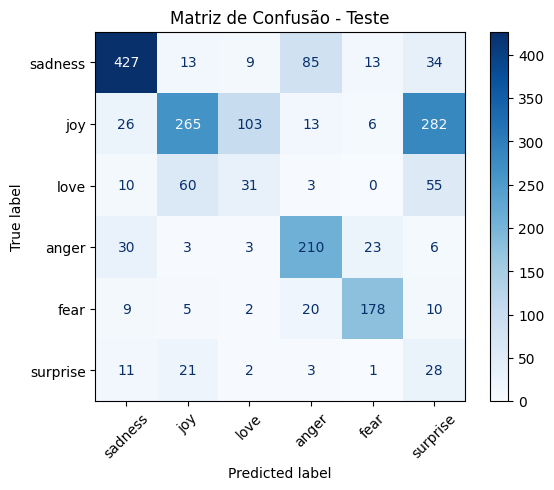

In [ ]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset["train"].features["label"].names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de Confusão - Teste")
plt.show()
